In [1]:
import matplotlib.pyplot as plt
import json
import itertools
import pandas as pd
import numpy as np

In [2]:
with open('results_test.json') as f:
    data = json.load(f)
    
data_list = []

for run_idx, run in enumerate(data):
    for planner_run in run['planner_runs']:
        data_list.append({
            'run_idx': run_idx,
            'apples': run['number_of_apples'],
            **planner_run
        })
            
data_df = pd.DataFrame(data_list).sort_values('run_idx')
data_df['mean_per_target_path_length'] = data_df.total_path_length / data_df.apples
data_df = data_df.set_index(['run_idx','intermediate_planner','order_planning', 'optimization_objective','custom_sampling'])

In [3]:
data_df

apples  \
run_idx intermediate_planner order_planning optimization_objective custom_sampling           
0       PRMstar              1-NNProb2OPT   Path Length            False                10   
                                                                   True                 10   
                             1-NN           Path Length            False                10   
                                                                   True                 10   
                             U-1-NN         Path Length            False                10   
...                                                                                    ...   
9       PRMstar              U-1-NN         Path Length            False                 5   
                             U-2-NN         Path Length            False                 5   
                             U-3-NN         Path Length            False                 5   
                             U-1-NN         Path Length            True                  5   
                             U-3-NN         Path Length            True                  5   

                                                                                                            leaf_collisions_over_time  \
run_idx intermediate_planner order_planning optimization_objective custom_sampling                                                      
0       PRMstar              1-NNProb2OPT   Path Length            False            [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                                                                   True             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             1-NN           Path Length            False            [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                                                                   True             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-1-NN         Path Length            False            [{'contacts_ended': 0, 'new_leaves_in_contact'...   
...                                                                                                                               ...   
9       PRMstar              U-1-NN         Path Length            False            [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-2-NN         Path Length            False            [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-3-NN         Path Length            False            [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-1-NN         Path Length            True             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-3-NN         Path Length            True             [{'contacts_ended': 0, 'new_leaves_in_contact'...   

                                                                                    targets_visited  \
run_idx intermediate_planner order_planning optimization_objective custom_sampling                    
0       PRMstar              1-NNProb2OPT   Path Length            False                         10   
                                                                   True                          10   
                             1-NN           Path Length            False                         10   
                                                                   True                          10   
                             U-1-NN         Path Length            False                         10   
...                                                                                             ...   
9       PRMstar              U-1-NN         Path Length            False                          5   
                             U-2-NN         Path Length            False                          5   
                             U-3-NN         Path 

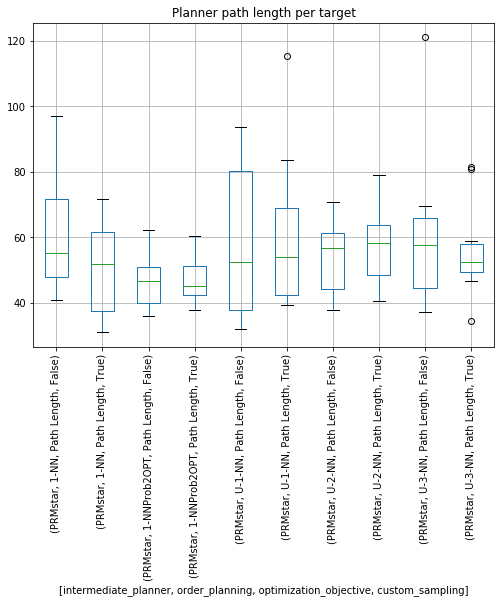

In [13]:
(data_df.total_path_length / data_df.targets_visited)\
    .to_frame()\
    .boxplot(by=['intermediate_planner','order_planning', 'optimization_objective','custom_sampling'], rot=90, figsize=(8,6))

# plt.ylim(0,30)
plt.title('Planner path length per target')
plt.suptitle('')
plt.savefig('path_length_per_target.png')
plt.show()

In [5]:
data_df[data_df.apples < 50]

apples  \
run_idx intermediate_planner order_planning optimization_objective custom_sampling           
0       PRMstar              1-NNProb2OPT   Path Length            False                10   
                                                                   True                 10   
                             1-NN           Path Length            False                10   
                                                                   True                 10   
                             U-1-NN         Path Length            False                10   
...                                                                                    ...   
9       PRMstar              U-1-NN         Path Length            False                 5   
                             U-2-NN         Path Length            False                 5   
                             U-3-NN         Path Length            False                 5   
                             U-1-NN         Path Length            True                  5   
                             U-3-NN         Path Length            True                  5   

                                                                                                            leaf_collisions_over_time  \
run_idx intermediate_planner order_planning optimization_objective custom_sampling                                                      
0       PRMstar              1-NNProb2OPT   Path Length            False            [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                                                                   True             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             1-NN           Path Length            False            [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                                                                   True             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-1-NN         Path Length            False            [{'contacts_ended': 0, 'new_leaves_in_contact'...   
...                                                                                                                               ...   
9       PRMstar              U-1-NN         Path Length            False            [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-2-NN         Path Length            False            [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-3-NN         Path Length            False            [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-1-NN         Path Length            True             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-3-NN         Path Length            True             [{'contacts_ended': 0, 'new_leaves_in_contact'...   

                                                                                    targets_visited  \
run_idx intermediate_planner order_planning optimization_objective custom_sampling                    
0       PRMstar              1-NNProb2OPT   Path Length            False                         10   
                                                                   True                          10   
                             1-NN           Path Length            False                         10   
                                                                   True                          10   
                             U-1-NN         Path Length            False                         10   
...                                                                                             ...   
9       PRMstar              U-1-NN         Path Length            False                          5   
                             U-2-NN         Path Length            False                          5   
                             U-3-NN         Path 

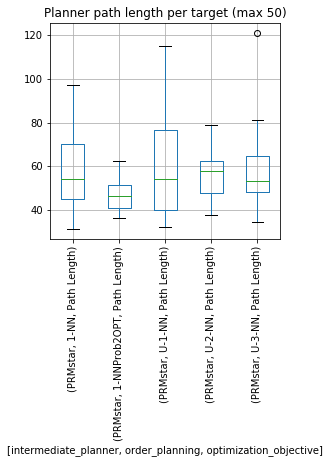

In [6]:
dlow = data_df[data_df.apples < 50]

(dlow.total_path_length / dlow.targets_visited)\
    .to_frame()\
    .boxplot(by=['intermediate_planner','order_planning', 'optimization_objective'], rot=90, figsize=(4,4))

# plt.ylim(0,30)
plt.title('Planner path length per target (max 50)')
plt.suptitle('')
plt.savefig('path_length_per_target.png')
plt.show()

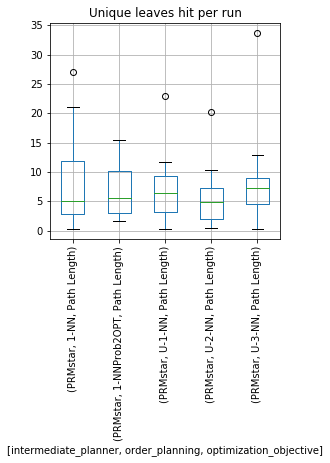

In [7]:
(data_df.unique_leaves_collided / data_df.targets_visited)\
    .to_frame()\
    .boxplot(by=['intermediate_planner','order_planning', 'optimization_objective'], rot=90, figsize=(4,4))

plt.title('Unique leaves hit per run')
plt.suptitle('')
plt.savefig('leaves_hit_per_target.png')
plt.show()

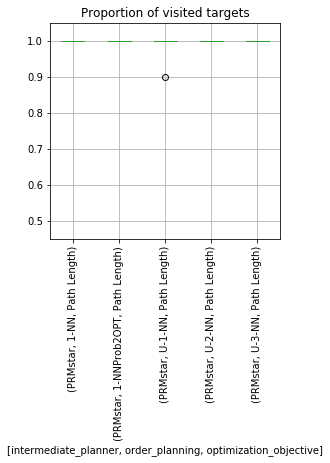

In [8]:
(data_df.targets_visited/ data_df.apples)\
    .to_frame()\
    .boxplot(by=['intermediate_planner','order_planning', 'optimization_objective'], rot=90, figsize=(4,4))

plt.ylim(0.45,1.05)
plt.title('Proportion of visited targets')
plt.suptitle('')
plt.savefig('proportion_visited_targets.png')
plt.show()